Step 1. 인물모드 직접 해 보기
-----

In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

In [2]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/park.jpeg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔 주세요. 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(853, 1280, 3)


- DeepLabModel 클래스

In [3]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

- load pretrained weight

In [4]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


In [5]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(853, 1280, 3) (341, 513, 3) 15


- 구글이 제공한 DeepLab은 PASCAL VOC의 라벨로 학습되었습니다<br/>종류를 봅시다.

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

- 자 여기서 사람(person)라벨 영역만 검출합시다.

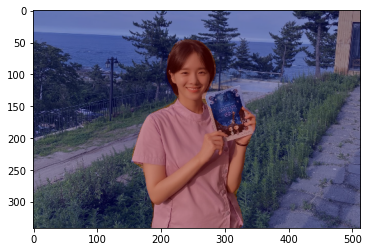

In [7]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 리사이즈 한 크기를 원래 크기로 복원!

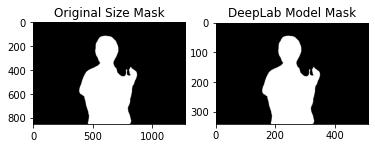

In [8]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

- 배경을 흐리게 만듭니다.

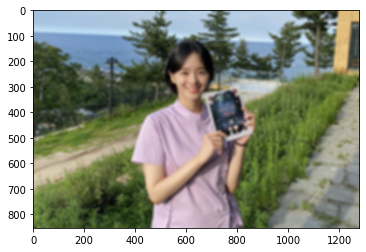

In [9]:
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 흐려진 이미지에서 세그멘테이션 마스크를 이용하여 배경만 추출합니다.

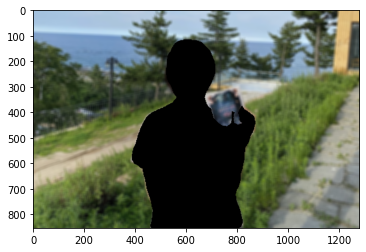

In [10]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color) #bitwise_not을 이용하면 이미지가 반전된다.배경 255,사람 0
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

- 다음으로는 배경과 사람을 합성하자!

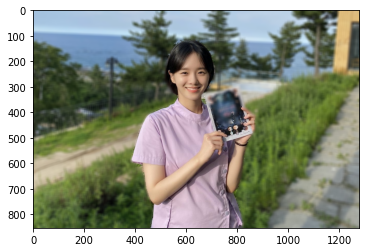

In [11]:
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 이번엔 다른 사진으로 시도해봅시다!

In [12]:
chim_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chim.jpeg'
chim_img_orig = cv2.imread(chim_img_path) 
print (chim_img_orig.shape)

(827, 620, 3)


In [13]:
chim_img_resized, chim_seg_map = MODEL.run(chim_img_orig)
print (chim_img_orig.shape, chim_img_resized.shape, chim_seg_map.max())

(827, 620, 3) (513, 384, 3) 15


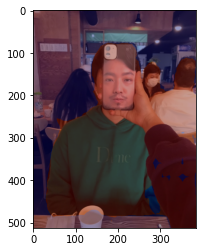

In [14]:
chim_img_show = chim_img_resized.copy()
chim_seg_map = np.where(chim_seg_map == 15, 15, 0) # 예측 중 사람만 추출
chim_img_mask = chim_seg_map * (255/chim_seg_map.max()) # 255 normalization
chim_img_mask = chim_img_mask.astype(np.uint8)
chim_color_mask = cv2.applyColorMap(chim_img_mask, cv2.COLORMAP_JET)
chim_img_show = cv2.addWeighted(chim_img_show, 0.6, chim_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(chim_img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 잘생겼네요
- 그리고 뒤에 있는 사람도 다 잡히는군요..

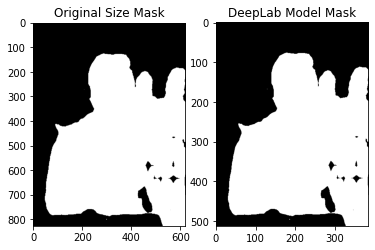

In [15]:
chim_img_mask_up = cv2.resize(chim_img_mask, chim_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, chim_img_mask_up = cv2.threshold(chim_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(chim_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(chim_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

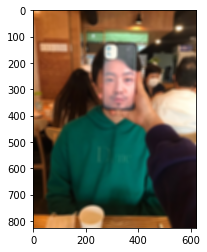

In [16]:
chim_img_orig_blur = cv2.blur(chim_img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(chim_img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

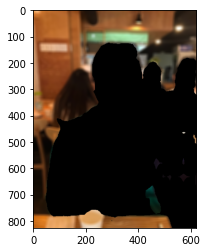

In [17]:
chim_img_mask_color = cv2.cvtColor(chim_img_mask_up, cv2.COLOR_GRAY2BGR)
chim_img_bg_mask = cv2.bitwise_not(chim_img_mask_color)
chim_img_bg_blur = cv2.bitwise_and(chim_img_orig_blur, chim_img_bg_mask)
plt.imshow(cv2.cvtColor(chim_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

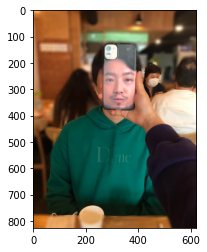

In [18]:
chim_img_concat = np.where(chim_img_mask_color==255, chim_img_orig, chim_img_bg_blur)
plt.imshow(cv2.cvtColor(chim_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 이번엔 배경을 합성해보자!!

In [19]:
kim_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/kim.png'
kim_img_orig = cv2.imread(kim_img_path) 
print (kim_img_orig.shape)

(794, 916, 3)


In [20]:
bg_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg.jpg'
bg_img_orig = cv2.imread(bg_img_path) 
print (bg_img_orig.shape)

(1080, 1920, 3)


In [21]:
kim_img_resized, kim_seg_map = MODEL.run(kim_img_orig)
print (kim_img_orig.shape, kim_img_resized.shape, kim_seg_map.max())

(794, 916, 3) (444, 513, 3) 15


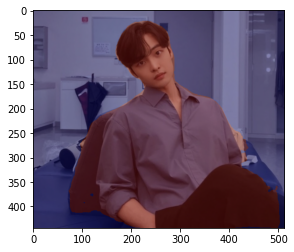

In [22]:
kim_img_show = kim_img_resized.copy()
kim_seg_map = np.where(kim_seg_map == 15, 15, 0) # 예측 중 사람만 추출
kim_img_mask = kim_seg_map * (255/kim_seg_map.max()) # 255 normalization
kim_img_mask = kim_img_mask.astype(np.uint8)
kim_color_mask = cv2.applyColorMap(kim_img_mask, cv2.COLORMAP_JET)
kim_img_show = cv2.addWeighted(kim_img_show, 0.6, kim_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(kim_img_show, cv2.COLOR_BGR2RGB))
plt.show()

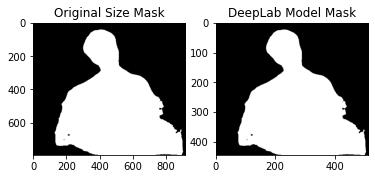

In [23]:
kim_img_mask_up = cv2.resize(kim_img_mask, kim_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, kim_img_mask_up = cv2.threshold(kim_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(kim_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(kim_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

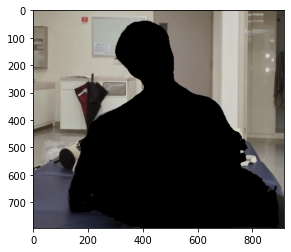

In [24]:
kim_img_mask_color = cv2.cvtColor(kim_img_mask_up, cv2.COLOR_GRAY2BGR)
kim_img_bg_mask = cv2.bitwise_not(kim_img_mask_color)
kim_img_bg = cv2.bitwise_and(kim_img_orig, kim_img_bg_mask)
plt.imshow(cv2.cvtColor(kim_img_bg, cv2.COLOR_BGR2RGB))
plt.show()

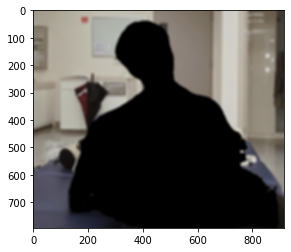

In [25]:
kim_img_bg_blur = cv2.blur(kim_img_bg, (13,13))
plt.imshow(cv2.cvtColor(kim_img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

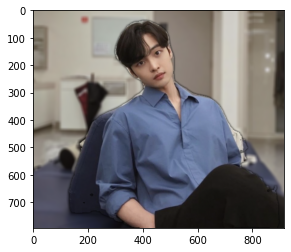

In [26]:
kim_img_concat = np.where(kim_img_mask_color==255, kim_img_orig, kim_img_bg_blur)
plt.imshow(cv2.cvtColor(kim_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

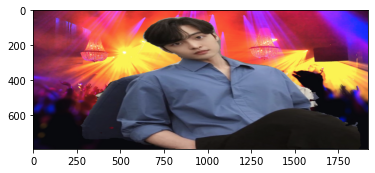

In [27]:
#인물,배경,마스크 리사이즈
kim_resized = cv2.resize(kim_img_orig, (bg_img_orig.shape[1], kim_img_orig.shape[0]))
bg_img_resized = cv2.resize(bg_img_orig, (bg_img_orig.shape[1], kim_img_orig.shape[0]))

kim_img_mask_resized = cv2.resize(kim_img_mask_color, (bg_img_orig.shape[1], kim_img_orig.shape[0]))
#합치기!
kim_bg_concat = np.where(kim_img_mask_resized == 255, kim_resized, bg_img_resized)

plt.imshow(cv2.cvtColor(kim_bg_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 비율이 요상하네요...<br/> 인물을 리사이즈하고 합성해보겠습니다

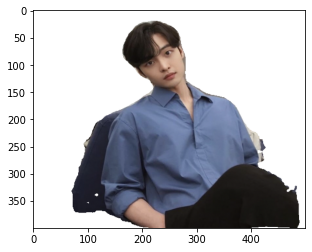

In [28]:
kim_re = np.where(kim_img_mask_color==255, kim_img_orig, 255)
kim_re = cv2.resize(kim_re, dsize=(500, 400), interpolation=cv2.INTER_CUBIC)
plt.imshow(cv2.cvtColor(kim_re, cv2.COLOR_BGR2RGB))
plt.show()

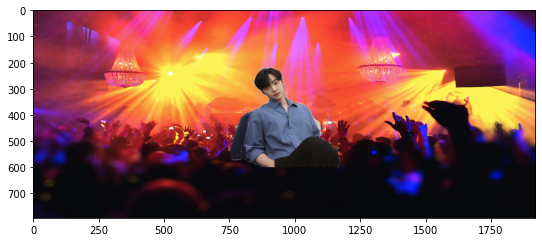

In [29]:
x = 680 #x,y 위치
y = 200

sticker_area = bg_img_resized[y:y+kim_re.shape[0], x:x+kim_re.shape[1]]
bg_img_resized[y:y+kim_re.shape[0], 
               x:x+kim_re.shape[1]] = np.where(kim_re==255,sticker_area,
                                                                 kim_re).astype(np.uint8)

plt.figure(figsize=(9,9))# 배경 크기
plt.imshow(cv2.cvtColor(bg_img_resized, cv2.COLOR_BGR2RGB))
plt.show()

- 클럽에 보내버렸는데 점잖은 모습...ㅋㅋㅋ

- 이번엔 귀여운 야옹이를 소환해봅시다.

In [30]:
cat_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'
cat_img_orig = cv2.imread(cat_img_path) 
print (kim_img_orig.shape)

(794, 916, 3)


In [31]:
bg2_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/bg2.jpeg'
bg2_img_orig = cv2.imread(bg2_img_path) 
print (bg2_img_orig.shape)

(900, 1440, 3)


In [32]:
cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max())

(512, 675, 3) (389, 513, 3) 8


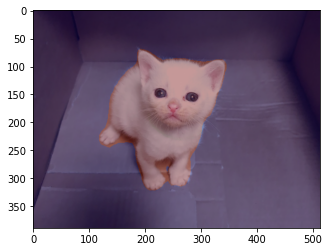

In [33]:
cat_img_show = cat_img_resized.copy()
cat_seg_map = np.where(cat_seg_map == 8, 8, 0) # 야옹이는 8이다
cat_img_mask = cat_seg_map * (255/cat_seg_map.max()) # 255 normalization
cat_img_mask = cat_img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(cat_img_show, 0.6, cat_color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()

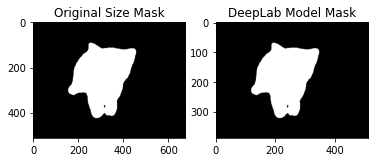

In [34]:
cat_img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(cat_img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(cat_img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(cat_img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

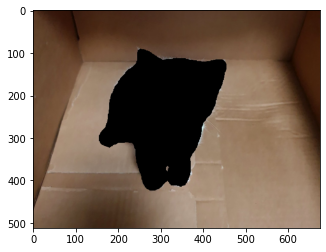

In [35]:
cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
cat_img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, cat_img_bg_mask)
plt.imshow(cv2.cvtColor(cat_img_bg, cv2.COLOR_BGR2RGB))
plt.show()

- 이번엔 야옹이를 우주로 보내버립시다!

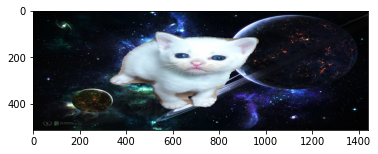

In [36]:
#인물,배경,마스크 리사이즈
cat_resized = cv2.resize(cat_img_orig, (bg2_img_orig.shape[1], cat_img_orig.shape[0]))
bg2_img_resized = cv2.resize(bg2_img_orig, (bg2_img_orig.shape[1], cat_img_orig.shape[0]))

cat_img_mask_resized = cv2.resize(cat_img_mask_color, (bg2_img_orig.shape[1], cat_img_orig.shape[0]))
#합치기!
cat_bg_concat = np.where(cat_img_mask_resized == 255, cat_resized, bg2_img_resized)

plt.imshow(cv2.cvtColor(cat_bg_concat, cv2.COLOR_BGR2RGB))
plt.show()

Step 2. 사진에서 문제점 찾기
-----

- 문제점을 하나하나 살펴봅시다!

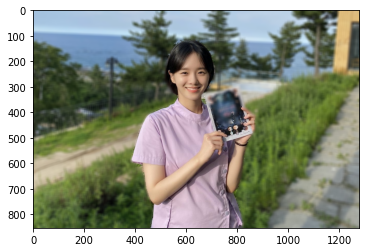

In [37]:
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 책까지 블러된 결과를 볼 수 있군요.<br/> 저작권을 지켜주는 모습입니다.

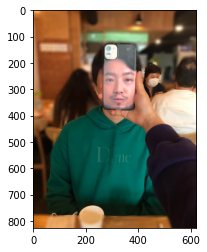

In [38]:
plt.imshow(cv2.cvtColor(chim_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 뒤에 있는 사람까지 포함되는 문제가 있네요.

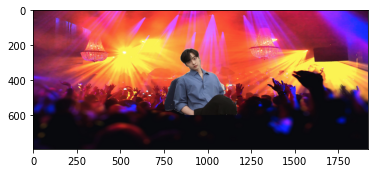

In [39]:
plt.imshow(cv2.cvtColor(bg_img_resized, cv2.COLOR_BGR2RGB))
plt.show()

- 인물이 작아서 안보이지만 영역처리가 아쉬운 부분이 있습니다.

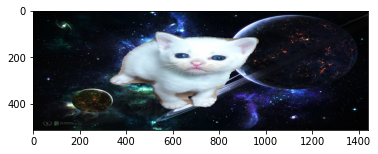

In [40]:
plt.imshow(cv2.cvtColor(cat_bg_concat, cv2.COLOR_BGR2RGB))
plt.show()

- 야옹이또한 영역처리가 아쉽습니다.

회고
----

- 사진이 깔끔하게 분리가 안되는 문제가 있다. <br/> 처리 방식은 포토샵과 비슷한것같은데 정확도의 차이가 아닐까싶다.<br/> 

- 직업특성상 누끼를 달고사는데 요새는 adobe에서 영상까지 누끼를 따준 후 빈공간을 합성하기도 한다.<br/> 그 기술이 궁금하고 관심이 많았는데 약간 맛보기로 해본거같아서 아주 흥미로운 EX였습니다..!

- 노드를 읽으면서 가장 흥미로웠던 부분은 아이폰의 인물사진 모드가 이런 원리라는것!<br/> 렌즈 심도가 안나오는 폰카메라에서 어떻게 이게 가능하지 싶었는데 이런 원리였다니!!!